# CNN VAE Training with varying latent size

In [18]:
import sys
import os
from os.path import join
parent_dir = os.path.abspath(join(os.getcwd(), os.pardir))
app_dir = join(parent_dir, "app")
if app_dir not in sys.path:
      sys.path.append(app_dir)

from pathlib import Path
import torch as pt
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from CNN_VAE import ConvDecoder, ConvEncoder, Autoencoder
from utils.training_loop import train_cnn_vae
import utils.config as config
from sklearn import metrics
import matplotlib.pyplot as plt
import importlib

importlib.reload(config)

pt.manual_seed(0)
plt.rcParams["figure.dpi"] = 180

# use GPU if possible
device = pt.device("cuda:0") if pt.cuda.is_available() else pt.device("cpu")

DATA_PATH = Path(os.path.abspath('')).parent / "data"
OUTPUT_PATH = Path(os.path.abspath('')).parent / "output" / "VAE" / "latent_study"

In [19]:
latent_sizes = list(range(10, 311, 50))
print(latent_sizes)

[10, 60, 110, 160, 210, 260, 310]


In [20]:
# load data
train_dataset = pt.load(join(DATA_PATH, "train_dataset.pt"))
val_dataset = pt.load(join(DATA_PATH, "val_dataset.pt"))
test_dataset = pt.load(join(DATA_PATH, "test_dataset.pt"))

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True)

In [21]:
# function to create VAE model
def make_VAE_model(n_latent: int = 256) -> pt.nn.Module:
    encoder = ConvEncoder(
        in_size=config.target_resolution,
        n_channels=config.input_channels,
        n_latent=config.latent_size,
        variational=True,
        layernorm=True
    )

    decoder = ConvDecoder(
        in_size=config.target_resolution,
        n_channels=config.output_channels,
        n_latent=config.latent_size,
        layernorm=True,
        squash_output=True
    )

    autoencoder = Autoencoder(encoder, decoder)
    autoencoder.to(device)
    return autoencoder

In [22]:
# start study
print("Running study...")
results = []
for latent_size in latent_sizes:
    print("Training autoencoder with {} bottleneck neurons ...".format(latent_size))
    model = make_VAE_model(latent_size)
    optimizer = pt.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = pt.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.2)

    results.append(train_cnn_vae(
        model=model,
        loss_func=nn.MSELoss(),
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=config.epochs,
        optimizer=optimizer,
        lr_schedule=scheduler,
    ))
    # create directory to save model state
    subfolder = "../output/VAE/latent_study/" + str(latent_size)
    !mkdir -p $subfolder
    model.save(str(join(OUTPUT_PATH, str(latent_size), str(latent_size))))
    print("\n")
pt.save(results, join(OUTPUT_PATH, "training_results.pt"))

Running study...
Training autoencoder with 10 bottleneck neurons ...
 Epoch  199/199 - Training loss: 6.247742e-03; Validation loss: 6.742448e-03/home/anton/repositories/Studienarbeit/output/VAE/latent_study/10/10_encoder.pt


Training autoencoder with 60 bottleneck neurons ...
 Epoch  199/199 - Training loss: 9.932908e-03; Validation loss: 1.032536e-02/home/anton/repositories/Studienarbeit/output/VAE/latent_study/60/60_encoder.pt


Training autoencoder with 110 bottleneck neurons ...
 Epoch  199/199 - Training loss: 9.307602e-02; Validation loss: 9.560139e-02/home/anton/repositories/Studienarbeit/output/VAE/latent_study/110/110_encoder.pt


Training autoencoder with 160 bottleneck neurons ...
 Epoch  199/199 - Training loss: 5.555131e-03; Validation loss: 7.373733e-03/home/anton/repositories/Studienarbeit/output/VAE/latent_study/160/160_encoder.pt


Training autoencoder with 210 bottleneck neurons ...
 Epoch  199/199 - Training loss: 5.516342e-03; Validation loss: 7.254943e-03/home/an

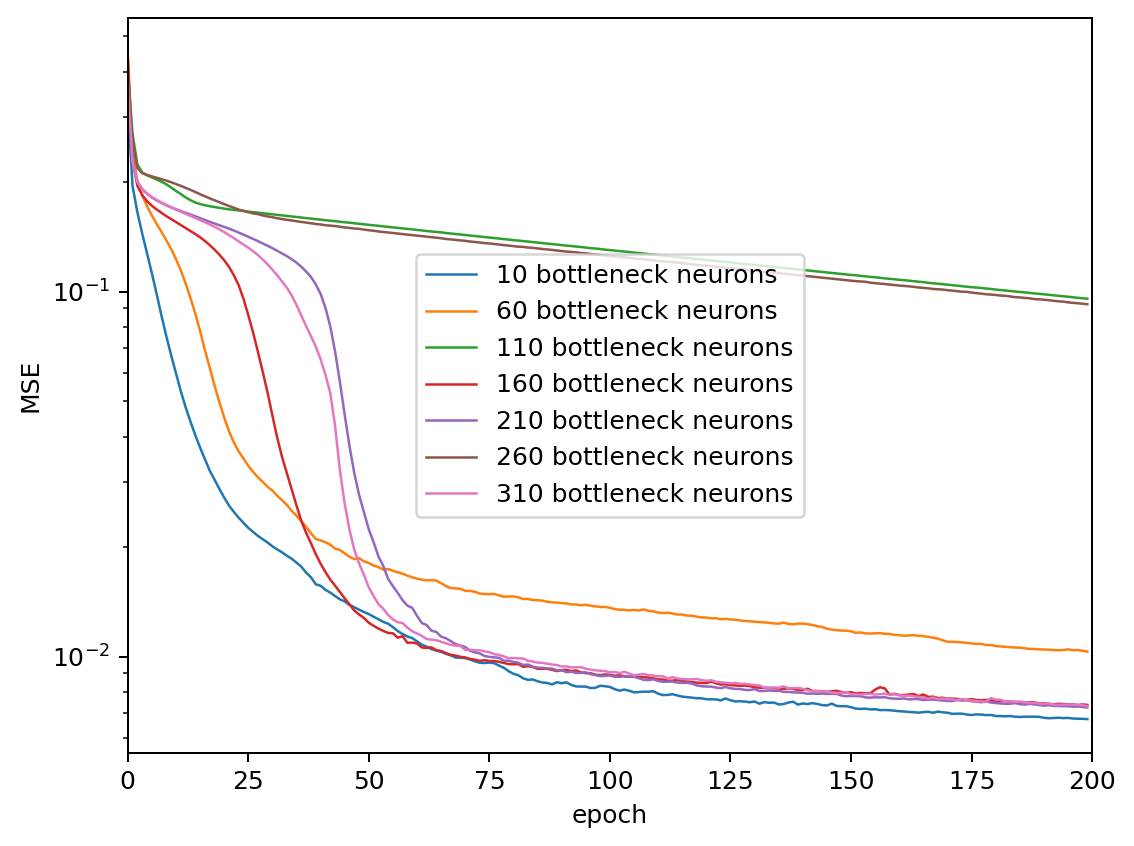

In [23]:
results = pt.load(join(OUTPUT_PATH, "training_results.pt"))
# plot study results, this will be in the "Training the Autoencoder" chapter
for i, latent_size in enumerate(latent_sizes):
    plt.plot(results[i]["epoch"], results[i]["val_loss"], lw=1, label="{} bottleneck neurons".format(latent_size))

plt.yscale("log")
plt.xlim(0, config.epochs)
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.savefig(join(Path(OUTPUT_PATH).parent, "Val_loss_results.png"))